In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from preprocessing import clean

In [ ]:
#set the path to where the data is saved
df = pd.read_csv('path/to/data.csv')

# Data Preprocess

In [ ]:
split_time = int(0.8*len(df))

In [ ]:
clean_df = clean(df)

train_m = np.array(clean_df.loc[:split_time, 'foF2m'])
test_m = np.array(clean_df.loc[split_time:, 'foF2m'])
train_o = np.array(clean_df.loc[:split_time, 'foF2o'])
test_o = np.array(clean_df.loc[split_time:, 'foF2o'])

# 2. GBRT

In [ ]:
xgb.set_config(verbosity=0)

def xgb_univar(scaled_train, scaled_test, w, a):
  X_train = np.zeros((scaled_train.shape[0]-w-a, w)) #(Ntrain-w-a x w)
  X_test = np.zeros((scaled_test.shape[0]-w-a, w)) #(Ntest-w-a x w)
  for wi in range(w):
    X_train[:,wi] = scaled_train[wi:-w-a+wi]#, 0]
    X_test[:,wi] = scaled_test[wi:-w-a+wi]#, 0]

  Y_train = scaled_train[w+a:] #(Ntrain-w-a x 1)
  Y_test = scaled_test[w+a:] #(Ntest-w-a x 1)

  # Sx = 1/(scaled_train.shape[0]-w-a) * np.matmul(X_train.T, X_train) #(w x w)
  # Sxy = 1/(scaled_train.shape[0]-w-a) * np.matmul(X_train.T, Y_train) #(w x 1)
  # wOLS = np.matmul(np.linalg.inv(Sx), Sxy) #(w x 1)
  # bOLS = np.mean(Y_train) - np.matmul(np.mean(X_train, axis=0), wOLS) #(1 x 1)

  # Y_pred = np.matmul(X_test, wOLS) + bOLS
  xgb_model=xgb.XGBRegressor(learning_rate =0.2,
                              n_estimators=150,
                              max_depth=8,
                              min_child_weight=1,
                              gamma=0.0,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              scale_pos_weight=1,
                              seed=42,
                              silent=True,
                              verbosity=0)
  xgb.set_config(verbosity=0)

  xgb_out = xgb_model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=False)

  Y_pred = xgb_out.predict(X_test)

  return Y_test, Y_pred

### 1-hour predict | 2,8,24 windows

Text(0.5, 1.0, '1-hour prediction')

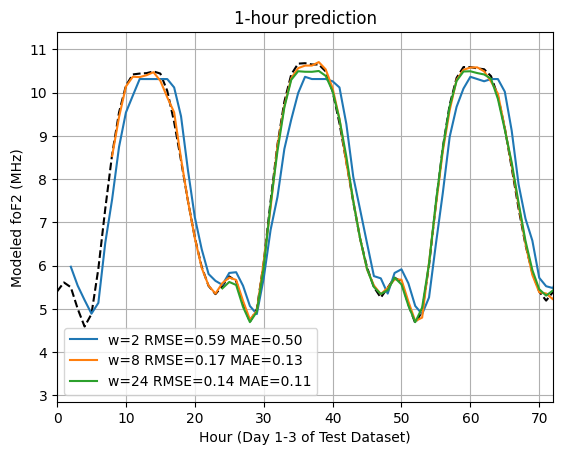

In [ ]:
a=0 #(1 hours)
plt.plot(np.arange(test_m.shape[0]), test_m, 'k--')
for w in [2,8,24]:
  Y_test, Y_pred = xgb_univar(train_m, test_m, w, a)
  # Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))
  # Y_pred = scaler.inverse_transform(Y_pred.reshape(-1, 1))
  RMSE = np.sqrt(np.mean((Y_pred - Y_test)**2))
  MAE = np.mean(np.abs(Y_pred - Y_test))
  plt.plot(np.arange(w, test_m.shape[0]), Y_pred, label=f'w={w} RMSE={RMSE:.2f} MAE={MAE:.2f}')
plt.xlim(0,24*3)
plt.legend()
plt.grid()
plt.xlabel('Hour (Day 1-3 of Test Dataset)')
plt.ylabel('Modeled foF2 (MHz)')
plt.title('1-hour prediction')

### 4-hour

Text(0.5, 1.0, '4-hour prediction')

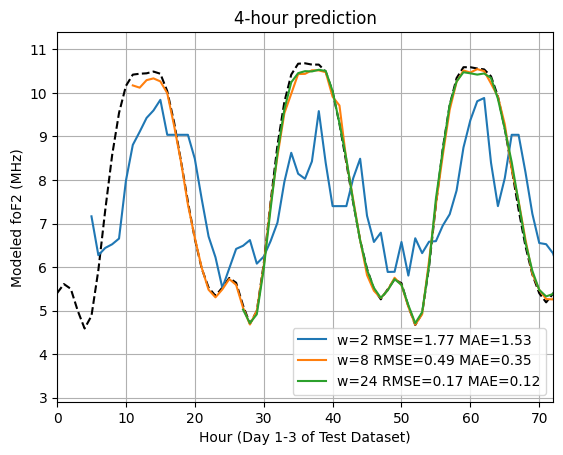

In [ ]:
a=3 #(1 hours)
plt.plot(np.arange(test_m.shape[0]), test_m, 'k--')
for w in [2,8,24]:
  Y_test, Y_pred = xgb_univar(train_m, test_m, w, a)
  # Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))
  # Y_pred = scaler.inverse_transform(Y_pred.reshape(-1, 1))
  RMSE = np.sqrt(np.mean((Y_pred - Y_test)**2))
  MAE = np.mean(np.abs(Y_pred - Y_test))
  plt.plot(np.arange(w+a, test_m.shape[0]), Y_pred, label=f'w={w} RMSE={RMSE:.2f} MAE={MAE:.2f}')
plt.xlim(0,24*3)
plt.legend()
plt.grid()
plt.xlabel('Hour (Day 1-3 of Test Dataset)')
plt.ylabel('Modeled foF2 (MHz)')
plt.title('4-hour prediction')

### 24-hour

Text(0.5, 1.0, '24-hour prediction')

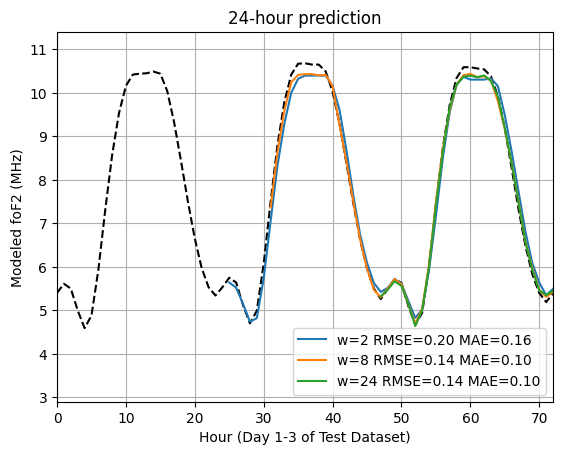

In [ ]:
a=23 #(1 hours)
plt.plot(np.arange(test_m.shape[0]), test_m, 'k--')
for w in [2,8,24]:
  Y_test, Y_pred = xgb_univar(train_m, test_m, w, a)
  # Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))
  # Y_pred = scaler.inverse_transform(Y_pred.reshape(-1, 1))
  RMSE = np.sqrt(np.mean((Y_pred - Y_test)**2))
  MAE = np.mean(np.abs(Y_pred - Y_test))
  plt.plot(np.arange(w+a, test_m.shape[0]), Y_pred, label=f'w={w} RMSE={RMSE:.2f} MAE={MAE:.2f}')
plt.xlim(0,24*3)
plt.legend()
plt.grid()
plt.xlabel('Hour (Day 1-3 of Test Dataset)')
plt.ylabel('Modeled foF2 (MHz)')
plt.title('24-hour prediction')

### gbrt window vs. forecast delay

In [ ]:
RMSE_m_uni_gbrt = np.zeros((len(range(0,49,8)),len(range(2,49,8)))) * np.nan
RMSE_o_uni_gbrt = np.zeros((len(range(0,49,8)),len(range(2,49,8)))) * np.nan
for ai,a in enumerate(range(0,49,8)):
  print("ai: ",ai)
  print("a: ",a)
  for wi,w in enumerate(range(2,49,8)):
    print("wi: ",wi)
    print("w: ",w)
    Y_test, Y_pred = xgb_univar(train_m, test_m, w, a)
    RMSE_m_uni_gbrt[ai,wi] = np.sqrt(np.mean((Y_pred - Y_test)**2))
    Y_test, Y_pred = xgb_univar(train_o, test_o, w, a)
    RMSE_o_uni_gbrt[ai,wi] = np.sqrt(np.mean((Y_pred - Y_test)**2))


ai:  0
a:  0
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42
ai:  1
a:  8
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42
ai:  2
a:  16
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42
ai:  3
a:  24
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42
ai:  4
a:  32
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42
ai:  5
a:  40
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42
ai:  6
a:  48
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42


<ipython-input-21-b682c9e36776>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,49,8))
<ipython-input-21-b682c9e36776>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(2,49,4))
<ipython-input-21-b682c9e36776>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,49,8))
<ipython-input-21-b682c9e36776>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(2,49,4))


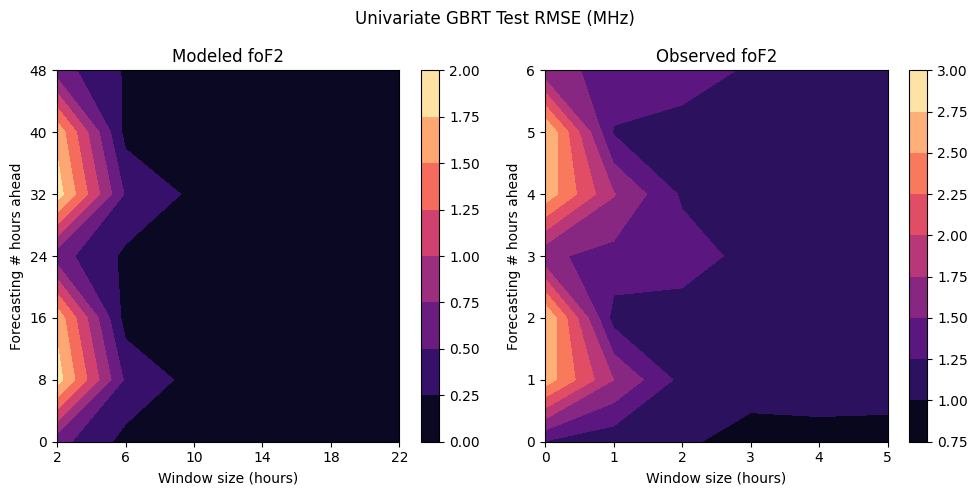

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))

cax = ax.contourf(RMSE_m_uni_gbrt, cmap='magma')
ax.set_xlabel('Window size (hours)')
ax.set_ylabel('Forecasting # hours ahead')
# ax.set_xticks(np.arange(0,47,4))
ax.set_yticklabels(np.arange(0,49,8))
ax.set_xticklabels(np.arange(2,49,4))
# ax.set_yticks(np.arange(0,49,4))
ax.set_title('Modeled foF2')
fig.colorbar(cax)

cax2 = ax2.contourf(RMSE_o_uni_gbrt, cmap='magma')
ax2.set_xlabel('Window size (hours)')
ax2.set_ylabel('Forecasting # hours ahead')
# ax2.set_xticks(np.arange(0,47,4))
ax.set_yticklabels(np.arange(0,49,8))
ax.set_xticklabels(np.arange(2,49,4))
# ax.set_yticks(np.arange(0,49,4))
ax2.set_title('Observed foF2')
fig.colorbar(cax2)
plt.suptitle("Univariate GBRT Test RMSE (MHz)")

plt.tight_layout()

### windows vs. time Covars, gbrt

In [ ]:
def xgb_allvar(scaled_train, scaled_test, clean_df, w, a, split_time=split_time):
  X_train = np.zeros((scaled_train.shape[0]-w-a, w+5)) #(Ntrain-w-a x w+1)
  X_test = np.zeros((scaled_test.shape[0]-w-a, w+5)) #(Ntest-w-a x w+1)
  for wi in range(w):
    X_train[:,wi] = scaled_train[wi:-w-a+wi]
    X_test[:,wi] = scaled_test[wi:-w-a+wi]
  for ni,n in enumerate(['DOY.h', 'SSN', 'Kp', 'Dst', 'TEC']):
    n_train = np.array(clean_df.loc[:split_time, n])
    if ni==0: X_train[:,w+ni] = n_train[w+a:]
    else: X_train[:,w+ni] = n_train[w+a-1:-1]
    n_test = np.array(clean_df.loc[split_time:, n])
    if ni==0: X_test[:,w+ni] = n_test[w+a:]
    else: X_test[:,w+ni] = n_test[w+a-1:-1]

  Y_train = scaled_train[w+a:] #(Ntrain-w-a x 1)
  Y_test = scaled_test[w+a:] #(Ntest-w-a x 1)

  xgb_model=xgb.XGBRegressor(learning_rate =0.2,
                              n_estimators=150,
                              max_depth=8,
                              min_child_weight=1,
                              gamma=0.0,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              scale_pos_weight=1,
                              seed=42,
                              silent=True,
                              verbosity=0)
  xgb.set_config(verbosity=0)
  xgb_out = xgb_model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=False)
  Y_pred = xgb_out.predict(X_test)

  return Y_test, Y_pred

In [ ]:
RMSE_m_covar_gbrt = np.zeros((len(range(0,49,8)),len(range(2,49,8)))) * np.nan
RMSE_o_covar_gbrt = np.zeros((len(range(0,49,8)),len(range(2,49,8)))) * np.nan
for ai,a in enumerate(range(0,49,8)):
  print("ai: ",ai)
  print("a: ",a)
  for wi,w in enumerate(range(2,49,8)):
    print("wi: ",wi)
    print("w: ",w)
    Y_test, Y_pred = xgb_allvar(train_m, test_m, clean_df, w, a)
    RMSE_m_covar_gbrt[ai,wi] = np.sqrt(np.mean((Y_pred - Y_test)**2))
    Y_test, Y_pred = xgb_allvar(train_o, test_o, clean_df, w, a)
    RMSE_o_covar_gbrt[ai,wi] = np.sqrt(np.mean((Y_pred - Y_test)**2))

ai:  0
a:  0
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42
ai:  1
a:  8
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42
ai:  2
a:  16
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42
ai:  3
a:  24
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42
ai:  4
a:  32
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42
ai:  5
a:  40
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42
ai:  6
a:  48
wi:  0
w:  2
wi:  1
w:  10
wi:  2
w:  18
wi:  3
w:  26
wi:  4
w:  34
wi:  5
w:  42


In [ ]:
print(RMSE_m_covar_gbrt)
print(RMSE_o_covar_gbrt.shape)

[[0.64649312 0.51086251 0.61773065 0.13494863 0.1255821  0.12877254]
 [1.16503175 1.2439646  0.15985292 0.17452041 0.14067566 0.14621769]
 [1.03538004 0.14646495 0.14090531 0.14180744 0.13907579 0.1383453 ]
 [0.68880422 0.54990943 0.62908277 0.17584669 0.16376465 0.16768466]
 [1.09703814 1.14538174 0.1870878  0.21741677 0.17961979 0.17732933]
 [1.09729707 0.18034167 0.16145628 0.17446647 0.17187751 0.16592808]
 [0.67415599 0.60859164 0.58542122 0.193486   0.18644227 0.19756816]]
(7, 6)


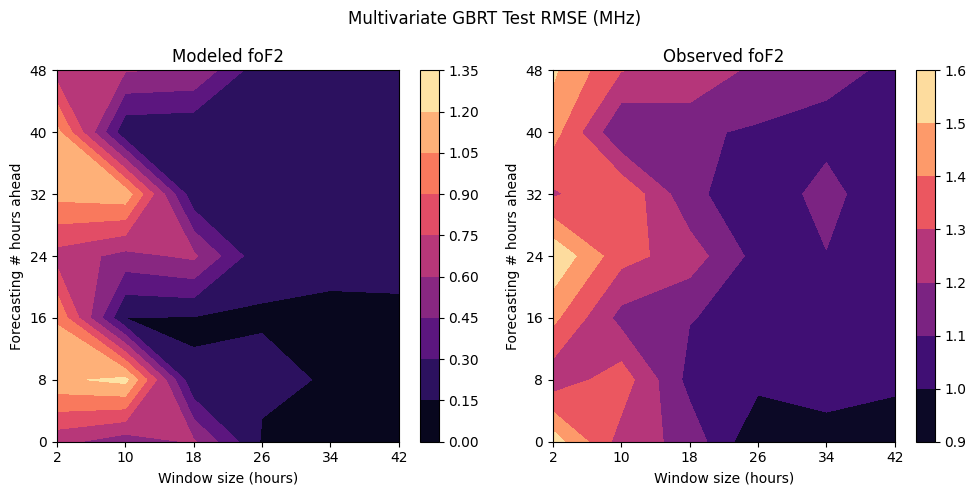

In [ ]:
# print_m = RMSE_m_covar_gbrt
# print_m[0,0] = 0
# print_m[-1,-1] = 2
# print_o = RMSE_m_covar_gbrt
# print_o[0,0] = 0
# print_o[-1,-1] = 2

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))

cax = ax.contourf(RMSE_m_covar_gbrt, cmap='magma')
ax.set_xlabel('Window size (hours)')
ax.set_ylabel('Forecasting # hours ahead')
ax.set_yticks(np.arange(0,len(range(0,49,8)),1))
ax.set_xticks(np.arange(0,len(range(2,49,8)),1))
ax.set_yticklabels(np.arange(0,49,8))
ax.set_xticklabels(np.arange(2,49,8))
ax.set_title('Modeled foF2')
fig.colorbar(cax)

cax2 = ax2.contourf(RMSE_o_covar_gbrt, cmap='magma')
ax2.set_xlabel('Window size (hours)')
ax2.set_ylabel('Forecasting # hours ahead')
ax2.set_yticks(np.arange(0,len(range(0,49,8)),1))
ax2.set_xticks(np.arange(0,len(range(2,49,8)),1))
ax2.set_yticklabels(np.arange(0,49,8))
ax2.set_xticklabels(np.arange(2,49,8))
ax2.set_title('Observed foF2')
fig.colorbar(cax2)
plt.suptitle("Multivariate GBRT Test RMSE (MHz)")

plt.tight_layout()

### gbrt day window of same hour

In [ ]:
# RMSE_m = np.zeros((24,21)) * np.nan
# RMSE_o = np.zeros((24,21)) * np.nan
RMSE_m_covar_gbrt_day = np.zeros((len(range(0,24,3)),len(range(2,43,5)))) * np.nan
RMSE_o_covar_gbrt_day = np.zeros((len(range(0,24,3)),len(range(2,43,5)))) * np.nan
for hi,h in enumerate(range(0,24,3)):
  print("!!!h: ", h)
  for wi,w in enumerate(range(2,43,5)):
    # print("w: ", w)
    Y_test, Y_pred = xgb_allvar(train_m[h::24], test_m[h::24], clean_df.loc[h::24], w, 0)
    RMSE_m_covar_gbrt_day[hi,wi] = np.sqrt(np.mean((Y_pred-Y_test)**2))
    Y_test, Y_pred = xgb_allvar(train_o[h::24], test_o[h::24], clean_df.loc[h::24], w, 0)
    RMSE_o_covar_gbrt_day[hi,wi] = np.sqrt(np.mean((Y_pred-Y_test)**2))

!!!h:  0
!!!h:  3
!!!h:  6
!!!h:  9
!!!h:  12
!!!h:  15
!!!h:  18
!!!h:  21


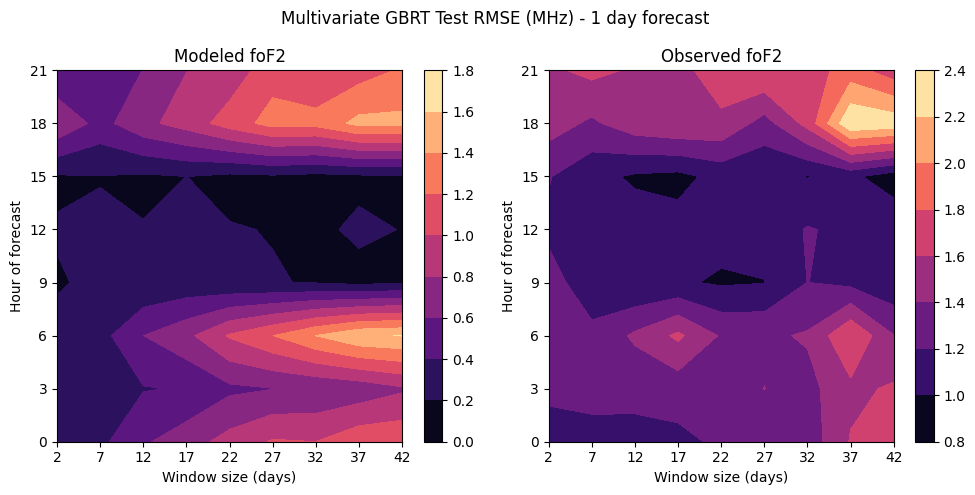

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))

cax = ax.contourf(RMSE_m_covar_gbrt_day, cmap='magma')
ax.set_xlabel('Window size (days)')
ax.set_ylabel('Hour of forecast')
ax.set_yticks(np.arange(0,len(range(0,24,3)),1))
ax.set_yticklabels(np.arange(0,24,3))
ax.set_xticks(np.arange(0,len(range(2,43,5)),1))
ax.set_xticklabels(np.arange(2,43,5))
ax.set_title('Modeled foF2')
fig.colorbar(cax)

cax2 = ax2.contourf(RMSE_o_covar_gbrt_day, cmap='magma')
ax2.set_xlabel('Window size (days)')
ax2.set_ylabel('Hour of forecast')
ax2.set_yticks(np.arange(0,len(range(0,24,3)),1))
ax2.set_yticklabels(np.arange(0,24,3))
ax2.set_xticks(np.arange(0,len(range(2,43,5)),1))
ax2.set_xticklabels(np.arange(2,43,5))
ax2.set_title('Observed foF2')
fig.colorbar(cax2)
plt.suptitle('Multivariate GBRT Test RMSE (MHz) - 1 day forecast')

plt.tight_layout()

0
2
4
6
8
10
12
14
16
18
20
22


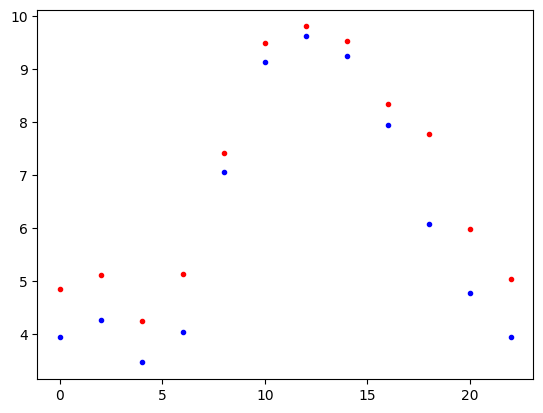

In [ ]:
a=0 #(1 hours)
w = 24
# plt.plot(np.arange(test_m.shape[0]), test_m, 'k--')
for h in range(0,24,2):
  print(h)
  Y_test, Y_pred = xgb_allvar(train_m[h::24], test_m[h::24], clean_df.loc[h::24], w, 0)
  # Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))
  # Y_pred = scaler.inverse_transform(Y_pred.reshape(-1, 1))
  # RMSE = np.sqrt(np.mean((Y_pred - Y_test)**2))
  # MAE = np.mean(np.abs(Y_pred - Y_test))
  Y_test1 =Y_test[-1]
  Y_pred1 =Y_pred[-1]
  plt.plot(h,Y_test1,'b.')
  plt.plot(h,Y_pred1,'r.')

# plt.xlim(0,24*3)
# plt.legend()
# plt.grid()
# plt.xlabel('Hour (Day 1-3 of Test Dataset)')
# plt.ylabel('Modeled foF2 (MHz)')
# plt.title('1-hour prediction')


# Y_test, Y_pred = xgb_allvar(train_m[h::24], test_m[h::24], clean_df.loc[h::24], w, 0)
# # Y_test, Y_pred = xgb_allvar(train_o[h::24], test_o[h::24], clean_df.loc[h::24], w, 0)
# plt.plot(Y_pred)
# plt.plot(Y_test)

In [ ]:
RMSE_m_covar_gbrt_day.shape
# len(RMSE_m_covar_gbrt_day)

(6, 6)

### gbrt hour of forecast, 24 hour forecast

In [ ]:
RMSE_m_covar_gbrt_hour = np.zeros((len(range(0,24,3)),len(range(2,49,5)))) * np.nan
RMSE_o_covar_gbrt_hour = np.zeros((len(range(0,24,3)),len(range(2,49,5)))) * np.nan
for wi,w in enumerate(range(2,49,5)):
  print('w:', w)
  Y_test, Y_pred = xgb_allvar(train_m, test_m, clean_df, w, 23)
  RMSE_m_covar_gbrt_hour[:,wi] = [np.sqrt(np.mean((Y_pred[h::24] - Y_test[h::24])**2)) for h in range(0,24,3)]
  Y_test, Y_pred = xgb_allvar(train_o, test_o, clean_df, w, 23)
  RMSE_o_covar_gbrt_hour[:,wi] = [np.sqrt(np.mean((Y_pred[h::24] - Y_test[h::24])**2)) for h in range(0,24,3)]

w: 2
w: 7
w: 12
w: 17
w: 22
w: 27
w: 32
w: 37
w: 42
w: 47


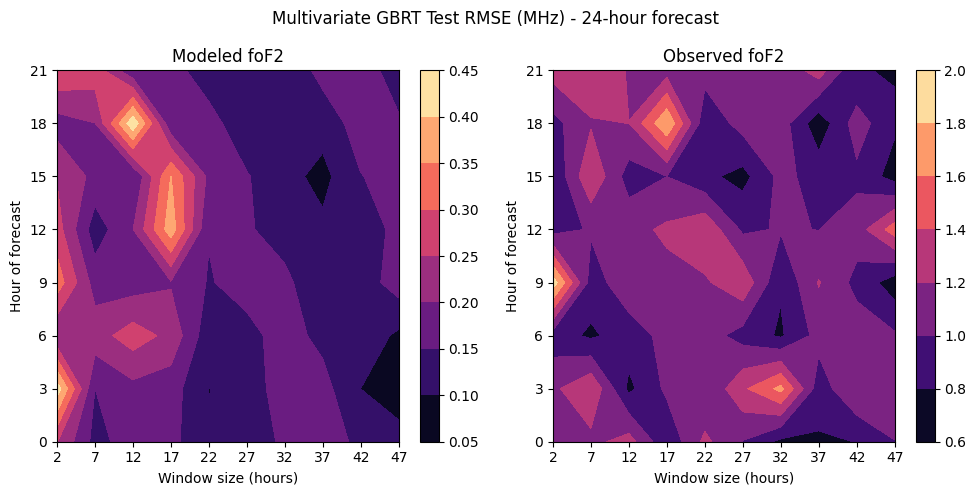

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))

cax = ax.contourf(RMSE_m_covar_gbrt_hour, cmap='magma')
ax.set_xlabel('Window size (hours)')
ax.set_ylabel('Hour of forecast')
ax.set_xticks(np.arange(0,len(range(2,49,5)),1))
ax.set_xticklabels(np.arange(2,49,5))
ax.set_yticks(np.arange(0,len(range(0,24,3)),1))
ax.set_yticklabels(np.arange(0,24,3))
ax.set_title('Modeled foF2')
fig.colorbar(cax)

cax2 = ax2.contourf(RMSE_o_covar_gbrt_hour, cmap='magma')
ax2.set_xlabel('Window size (hours)')
ax2.set_ylabel('Hour of forecast')
ax2.set_xticks(np.arange(0,len(range(2,49,5)),1))
ax2.set_xticklabels(np.arange(2,49,5))
ax2.set_yticks(np.arange(0,len(range(0,24,3)),1))
ax2.set_yticklabels(np.arange(0,24,3))
ax2.set_title('Observed foF2')
fig.colorbar(cax2)

fig.suptitle('Multivariate GBRT Test RMSE (MHz) - 24-hour forecast')
plt.tight_layout()